<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/CNN/CNN_Gilt10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 4.29 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 20:41:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Gilt10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'CNN'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [ ]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 12.3MB/s 
     |████████████████████████████████| 174kB 37.7MB/s 
     |████████████████████████████████| 102kB 8.8MB/s 
     |████████████████████████████████| 143kB 42.0MB/s 
     |████████████████████████████████| 143kB 40.7MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [ ]:
!pip install wandb -qq

In [ ]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['selu', 'relu']
        }
    }
}

In [ ]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Conv1D(filters=128, kernel_size=2, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Conv1D(filters=64, kernel_size=2, activation=config.activation))
    # layer 3
    model.add(MaxPooling1D(pool_size=2))
    # layer 4
    model.add(Flatten())
    # layer 5
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [ ]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: uv0og0k8
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_CNN/sweeps/uv0og0k8


In [ ]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: wr7y08ri with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
32/32 [==============================] - 33s 28ms/step - loss: 0.0803 - mean_squared_error: 0.0803 - mean_absolute_error: 0.1935 - val_loss: 0.0429 - val_mean_squared_error: 0.0429 - val_mean_absolute_error: 0.1757
Epoch 2/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0852 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1793
Epoch 3/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - mean_absolute_error: 0.0958 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1543
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0724 - val_loss: 0.0236 - val_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.1182
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 0.0103 - mean_squared_err

epoch,88
loss,0.00128
mean_squared_error,0.00128
mean_absolute_error,0.02773
val_loss,0.0087
val_mean_squared_error,0.0087
val_mean_absolute_error,0.07259
_runtime,62
_timestamp,1626538439
_step,88
best_val_loss,0.00757


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▅▃▂▃▄▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▅▃▂▃▄▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▄▅▄▃▄▄▂▂▂▂▃▂▂▁▂▂▁▃▁▂▂▁▁▁▁▁▁▁▂▁▃▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ce39r0r3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 69ms/step - loss: 7.6424 - mean_squared_error: 7.6424 - mean_absolute_error: 1.7512 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1490
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0689 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1430
Epoch 3/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0460 - val_loss: 0.0314 - val_mean_squared_error: 0.0314 - val_mean_absolute_error: 0.1420
Epoch 4/50
8/8 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0392 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1372
Epoch 5/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - m

epoch,33
loss,0.04405
mean_squared_error,0.04405
mean_absolute_error,0.15353
val_loss,1.59948
val_mean_squared_error,1.59948
val_mean_absolute_error,1.22451
_runtime,9
_timestamp,1626538458
_step,33
best_val_loss,0.01464


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▁▂▁▁▂▂▃▁▁▁▁▁▂▄▁▁▁▁▁▁▂▃▁▁▁▁▁▁▂
val_loss,▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁█
val_mean_squared_error,▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁█
val_mean_absolute_error,▁▁▁▁▂▁▃▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁█
_runtime,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆████████
_timestamp,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆▆▆▆████████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: euepzktb with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 2s 20ms/step - loss: 0.1404 - mean_squared_error: 0.1404 - mean_absolute_error: 0.2860 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1431
Epoch 2/200
32/32 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0558 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1505
Epoch 3/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0419 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1444
Epoch 4/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0381 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1343
Epoch 5/200
32/32 [==============================] - 0s 7ms/step - loss: 0.0018 - mean_squared_erro

epoch,36
loss,0.00052
mean_squared_error,0.00052
mean_absolute_error,0.01765
val_loss,0.00749
val_mean_squared_error,0.00749
val_mean_absolute_error,0.06561
_runtime,15
_timestamp,1626538483
_step,36
best_val_loss,0.00747


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,███▆▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: f2jxlst6 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 22ms/step - loss: 0.0592 - mean_squared_error: 0.0592 - mean_absolute_error: 0.1556 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1418
Epoch 2/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0550 - val_loss: 0.0208 - val_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.1096
Epoch 3/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0780 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1235
Epoch 4/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0414 - val_loss: 0.0164 - val_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0978
Epoch 5/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_err

epoch,43
loss,0.00063
mean_squared_error,0.00063
mean_absolute_error,0.01937
val_loss,0.0078
val_mean_squared_error,0.0078
val_mean_absolute_error,0.06865
_runtime,18
_timestamp,1626538512
_step,43
best_val_loss,0.00758


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▁▂▂▁▃▁▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
mean_squared_error,█▃▃▂▁▂▂▁▃▁▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
mean_absolute_error,█▅▅▄▂▃▄▂▅▂▃▃▂▂▃▂▂▄▁▂▂▁▁▂▂▂▁▂▂▂▁▁▂▁▃▁▁▁▂▁
val_loss,█▅▆▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▁▂▁▂▁▂▂▁▂▁▁▁▂▁▁▂▁▁▁
val_mean_squared_error,█▅▆▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▁▂▁▂▁▂▂▁▂▁▁▁▂▁▁▂▁▁▁
val_mean_absolute_error,█▅▆▄▃▄▄▄▃▂▂▃▃▃▃▂▂▃▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▃▁▁▂▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pmgb3i58 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 36ms/step - loss: 0.2052 - mean_squared_error: 0.2052 - mean_absolute_error: 0.3945 - val_loss: 0.0419 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1567
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0855 - val_loss: 0.0471 - val_mean_squared_error: 0.0471 - val_mean_absolute_error: 0.1874
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0628 - val_loss: 0.0370 - val_mean_squared_error: 0.0370 - val_mean_absolute_error: 0.1564
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0504 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1592
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0027 - mean_squared_erro

epoch,99
loss,0.00049
mean_squared_error,0.00049
mean_absolute_error,0.01704
val_loss,0.00766
val_mean_squared_error,0.00766
val_mean_absolute_error,0.06773
_runtime,23
_timestamp,1626538551
_step,99
best_val_loss,0.00723


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▇▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,████▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tiz032vr with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 22ms/step - loss: 0.2101 - mean_squared_error: 0.2101 - mean_absolute_error: 0.2956 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1662
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0442 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1262
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0423 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1053
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0331 - val_loss: 0.0154 - val_mean_squared_error: 0.0154 - val_mean_absolute_error: 0.0980
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_squared_error: 0.

epoch,49
loss,0.00059
mean_squared_error,0.00059
mean_absolute_error,0.01901
val_loss,0.00597
val_mean_squared_error,0.00597
val_mean_absolute_error,0.05876
_runtime,22
_timestamp,1626538585
_step,49
best_val_loss,0.00597


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▄▃▃▃▃▂▂▂▃▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sw6llszv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 69ms/step - loss: 0.1119 - mean_squared_error: 0.1119 - mean_absolute_error: 0.2322 - val_loss: 0.0737 - val_mean_squared_error: 0.0737 - val_mean_absolute_error: 0.2358
Epoch 2/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1142 - val_loss: 0.0377 - val_mean_squared_error: 0.0377 - val_mean_absolute_error: 0.1562
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0565 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1415
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0800 - val_loss: 0.0357 - val_mean_squared_error: 0.0357 - val_mean_absolute_error: 0.1432
Epoch 5/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0066 - mean_squared_error: 0.0

epoch,43
loss,0.00144
mean_squared_error,0.00144
mean_absolute_error,0.03053
val_loss,0.01257
val_mean_squared_error,0.01257
val_mean_absolute_error,0.0903
_runtime,12
_timestamp,1626538612
_step,43
best_val_loss,0.01064


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▅▃▄▃▂▂▁▄▃▃▃▃▂▂▂▃▃▂▂▂▃▂▁▃▂▂▃▁▁▂▁▂▃▂▂▂▁
val_loss,█▄▄▄▃▃▂▂▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▁▁▂▁▂▁▁▁
val_mean_squared_error,█▄▄▄▃▃▂▂▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▁▂▁▁▂▁▂▁▁▁
val_mean_absolute_error,█▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▃▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▂▂▂▁
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 8ffoiu0t with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 2s 35ms/step - loss: 0.0578 - mean_squared_error: 0.0578 - mean_absolute_error: 0.1598 - val_loss: 0.0541 - val_mean_squared_error: 0.0541 - val_mean_absolute_error: 0.1975
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0566 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1492
Epoch 3/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0077 - mean_squared_error: 0.0077 - mean_absolute_error: 0.0672 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1391
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0362 - val_loss: 0.0204 - val_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.1138
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0034 - mean_squared_err

epoch,71
loss,0.00046
mean_squared_error,0.00046
mean_absolute_error,0.01636
val_loss,0.00565
val_mean_squared_error,0.00565
val_mean_absolute_error,0.0574
_runtime,20
_timestamp,1626538644
_step,71
best_val_loss,0.0055


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▃▂▂▂▃▂▁▂▂▂▁▂▁▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁▂▁
val_loss,█▅▃▃▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▄▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: o00d2ros with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 22ms/step - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.1186 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1500
Epoch 2/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0537 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1007
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0458 - val_loss: 0.0162 - val_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.1007
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0351 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0969
Epoch 5/200
32/32 [==============================] - 0s 8ms/step - loss: 0.0023 - mean_squared_err

epoch,32
loss,0.00057
mean_squared_error,0.00057
mean_absolute_error,0.01844
val_loss,0.00789
val_mean_squared_error,0.00789
val_mean_absolute_error,0.06832
_runtime,17
_timestamp,1626538675
_step,32
best_val_loss,0.00595


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▃▂▂▃▁▂▁▂▂▁▁▁▂▂▁▁▁▁▆▁▁▂▁▁▁▁▁
val_loss,█▄▄▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▂
val_mean_squared_error,█▄▄▃▃▂▃▂▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▂▂▁▂▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: 6n6ivqki with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 2s 23ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1271 - val_loss: 0.0317 - val_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.1418
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0544 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1489
Epoch 3/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0628 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1077
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0397 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1041
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0

epoch,43
loss,0.00087
mean_squared_error,0.00087
mean_absolute_error,0.02328
val_loss,0.00817
val_mean_squared_error,0.00817
val_mean_absolute_error,0.07092
_runtime,21
_timestamp,1626538714
_step,43
best_val_loss,0.00701


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▃▄▃▅▄▃▃▃▂▃▃▂▂▃▂▂▃▂▂▃▂▁▃▂▃▂▁▁▂▁▁▁▂▁▂▁▂
val_loss,██▄▄▄▄▇▄▃▃▃▃▃▃▃▇▃▃▂▃▂▃▃▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▄▄▄▄▇▄▃▃▃▃▃▃▃▇▃▃▂▃▂▃▃▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▅▄▄▅▇▅▄▃▃▃▃▃▃▇▃▃▂▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: k4ycevmu with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 66ms/step - loss: 0.3638 - mean_squared_error: 0.3638 - mean_absolute_error: 0.4223 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1682
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0494 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1450
Epoch 3/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0896 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1529
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0582 - val_loss: 0.0475 - val_mean_squared_error: 0.0475 - val_mean_absolute_error: 0.1615
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - 

epoch,49
loss,0.00337
mean_squared_error,0.00337
mean_absolute_error,0.04632
val_loss,0.02071
val_mean_squared_error,0.02071
val_mean_absolute_error,0.11498
_runtime,11
_timestamp,1626538738
_step,49
best_val_loss,0.01552


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▂▂▁▁▂▂▁▁▁▁▂▁▁▁▁
val_loss,▆▆▅█▆▅▆▇▆▅▃▃▂▄▃▂▂▂▄▂▂▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▃▂
val_mean_squared_error,▆▆▅█▆▅▆▇▆▅▃▃▂▄▃▂▂▂▄▂▂▃▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▃▂
val_mean_absolute_error,█▆▆▇▆▅▆▇▆▅▄▃▃▄▃▂▂▂▅▂▂▃▂▂▁▂▁▁▁▁▁▁▂▁▁▁▂▃▄▃
_runtime,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▂▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: amh4vawy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 2s 20ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1578 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1573
Epoch 2/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0431 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1413
Epoch 3/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0357 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1401
Epoch 4/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0353 - val_loss: 0.0257 - val_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.1287
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0016 - mean_squared_error: 0.

epoch,49
loss,0.00049
mean_squared_error,0.00049
mean_absolute_error,0.01696
val_loss,0.00682
val_mean_squared_error,0.00682
val_mean_absolute_error,0.06316
_runtime,21
_timestamp,1626538770
_step,49
best_val_loss,0.00682


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▇▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rgjz3hwr with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 34ms/step - loss: 0.0877 - mean_squared_error: 0.0877 - mean_absolute_error: 0.1957 - val_loss: 0.0382 - val_mean_squared_error: 0.0382 - val_mean_absolute_error: 0.1656
Epoch 2/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0568 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1483
Epoch 3/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0499 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1433
Epoch 4/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0482 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1421
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0039 - mean_squared_erro

epoch,38
loss,0.00139
mean_squared_error,0.00139
mean_absolute_error,0.02909
val_loss,0.01247
val_mean_squared_error,0.01247
val_mean_absolute_error,0.08778
_runtime,13
_timestamp,1626538800
_step,38
best_val_loss,0.01104


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▆▄▄▄▃▃▂▃▂▂▂▂▃▃▂▁▁▁▃▂▁▁▁▂▁▁▂▁▁▂▁▁▂▁▁
val_mean_squared_error,█▇▆▆▆▄▄▄▃▃▂▃▂▂▂▂▃▃▂▁▁▁▃▂▁▁▁▂▁▁▂▁▁▂▁▁▂▁▁
val_mean_absolute_error,█▇▆▆▆▄▅▄▃▃▃▃▂▂▂▃▃▃▂▂▁▂▃▂▂▁▁▂▁▁▂▁▁▂▁▁▂▂▂
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: s2ldxcvb with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 2s 33ms/step - loss: 0.0747 - mean_squared_error: 0.0747 - mean_absolute_error: 0.2080 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1485
Epoch 2/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0694 - val_loss: 0.0270 - val_mean_squared_error: 0.0270 - val_mean_absolute_error: 0.1271
Epoch 3/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0395 - val_loss: 0.0219 - val_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.1185
Epoch 4/200
16/16 [==============================] - 0s 8ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0328 - val_loss: 0.0167 - val_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.1019
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0014 - mean_squared_erro

epoch,100
loss,0.00043
mean_squared_error,0.00043
mean_absolute_error,0.01593
val_loss,0.00589
val_mean_squared_error,0.00589
val_mean_absolute_error,0.05995
_runtime,23
_timestamp,1626538838
_step,100
best_val_loss,0.00558


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: dlf02g4n with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 33ms/step - loss: 0.0568 - mean_squared_error: 0.0568 - mean_absolute_error: 0.1597 - val_loss: 0.0374 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1561
Epoch 2/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0552 - val_loss: 0.0340 - val_mean_squared_error: 0.0340 - val_mean_absolute_error: 0.1466
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0464 - val_loss: 0.0311 - val_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.1380
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0507 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1315
Epoch 5/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0044 - mean_squared_error: 0

epoch,49
loss,0.0014
mean_squared_error,0.0014
mean_absolute_error,0.03054
val_loss,0.0089
val_mean_squared_error,0.0089
val_mean_absolute_error,0.07113
_runtime,15
_timestamp,1626538905
_step,49
best_val_loss,0.00823


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁
val_loss,█▇▆▆▅▆▅▅▃▃▃▃▂▄▃▂▂▂▃▂▂▂▂▂▃▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▆▅▆▅▅▃▃▃▃▂▄▃▂▂▂▃▂▂▂▂▂▃▂▃▂▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▆▇▅▅▃▃▃▃▃▄▃▂▂▂▃▃▂▂▂▂▃▂▃▂▁▂▁▂▁▁▂▂▁▁▁▁
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3a2tdafw with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 63ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - mean_absolute_error: 0.1602 - val_loss: 0.0356 - val_mean_squared_error: 0.0356 - val_mean_absolute_error: 0.1577
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0847 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1235
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0505 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1167
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0419 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1109
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0020 

epoch,99
loss,0.00057
mean_squared_error,0.00057
mean_absolute_error,0.01883
val_loss,0.00603
val_mean_squared_error,0.00603
val_mean_absolute_error,0.05971
_runtime,20
_timestamp,1626538938
_step,99
best_val_loss,0.00603


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: eqmmmlvi with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 2s 23ms/step - loss: 0.1216 - mean_squared_error: 0.1216 - mean_absolute_error: 0.2503 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1497
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0411 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1387
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0368 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1292
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0348 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1272
Epoch 5/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0019 - mean_squared_err

epoch,68
loss,0.00054
mean_squared_error,0.00054
mean_absolute_error,0.01821
val_loss,0.00796
val_mean_squared_error,0.00796
val_mean_absolute_error,0.06943
_runtime,29
_timestamp,1626538980
_step,68
best_val_loss,0.00652


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▂▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_squared_error,█▇▆▅▄▃▃▃▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▄▃▃▃▃▂▂▂▂▃▂▃▁▁▁▁▁▂▂▁▁▁▁▁▁▁▂▁▁▁▂▁▂▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z3rqoc8u with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 70ms/step - loss: 0.0863 - mean_squared_error: 0.0863 - mean_absolute_error: 0.1962 - val_loss: 0.0283 - val_mean_squared_error: 0.0283 - val_mean_absolute_error: 0.1366
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0563 - val_loss: 0.0413 - val_mean_squared_error: 0.0413 - val_mean_absolute_error: 0.1567
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - mean_absolute_error: 0.1055 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1247
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0362 - val_loss: 0.0225 - val_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.1209
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0020 - mean_squared_error: 0.00

wandb: Processing terminal ouput (stdout)...
wandb: Done.


epoch,83
loss,0.00046
mean_squared_error,0.00046
mean_absolute_error,0.01667
val_loss,0.00621
val_mean_squared_error,0.00621
val_mean_absolute_error,0.05998
_runtime,18
_timestamp,1626539022
_step,83
best_val_loss,0.00611


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▁▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▅▂▂▅▂▂▃▁▁▂▁▁▂▁▃▂▁▁▂▃▁▁▁▂▃▁▁▁▁▂▁▁▁▂▂▁▁
val_loss,█▇▆▅▅▄▅▄▄▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▅▄▅▄▄▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▆▄▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: w5allsk9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 20ms/step - loss: 0.3004 - mean_squared_error: 0.3004 - mean_absolute_error: 0.3279 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1202
Epoch 2/100
32/32 [==============================] - 0s 8ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0394 - val_loss: 0.0139 - val_mean_squared_error: 0.0139 - val_mean_absolute_error: 0.0944
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0276 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0817
Epoch 4/100
32/32 [==============================] - 0s 7ms/step - loss: 8.8580e-04 - mean_squared_error: 8.8580e-04 - mean_absolute_error: 0.0235 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0778
Epoch 5/100
32/32 [==============================] - 0s 7ms/step - loss: 8.1783e-04 - mean_

epoch,26
loss,0.00061
mean_squared_error,0.00061
mean_absolute_error,0.01951
val_loss,0.00615
val_mean_squared_error,0.00615
val_mean_absolute_error,0.06137
_runtime,14
_timestamp,1626539054
_step,26
best_val_loss,0.00567


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rcs60o9i with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 2s 67ms/step - loss: 0.2109 - mean_squared_error: 0.2109 - mean_absolute_error: 0.3961 - val_loss: 0.0405 - val_mean_squared_error: 0.0405 - val_mean_absolute_error: 0.1552
Epoch 2/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0143 - mean_squared_error: 0.0143 - mean_absolute_error: 0.0984 - val_loss: 0.0662 - val_mean_squared_error: 0.0662 - val_mean_absolute_error: 0.2252
Epoch 3/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0923 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1519
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0718 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_mean_absolute_error: 0.1570
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0043 - mean_squared_error: 0.004

epoch,140
loss,0.00049
mean_squared_error,0.00049
mean_absolute_error,0.01698
val_loss,0.00727
val_mean_squared_error,0.00727
val_mean_absolute_error,0.06578
_runtime,25
_timestamp,1626539102
_step,140
best_val_loss,0.00717


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: z0oqto9l with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 35ms/step - loss: 0.0798 - mean_squared_error: 0.0798 - mean_absolute_error: 0.2218 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1328
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0677 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1591
Epoch 3/50
16/16 [==============================] - 0s 8ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0498 - val_loss: 0.0287 - val_mean_squared_error: 0.0287 - val_mean_absolute_error: 0.1365
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0392 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1353
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0022 - mean_squared_error: 

epoch,49
loss,0.00057
mean_squared_error,0.00057
mean_absolute_error,0.01857
val_loss,0.00772
val_mean_squared_error,0.00772
val_mean_absolute_error,0.06746
_runtime,17
_timestamp,1626539137
_step,49
best_val_loss,0.00772


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆█▆▆▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆█▆▆▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆█▆▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ht5i946m with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 2s 72ms/step - loss: 0.0782 - mean_squared_error: 0.0782 - mean_absolute_error: 0.1804 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1469
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0473 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1559
Epoch 3/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0874 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1420
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0472 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1711
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0123 - mean_squared_error: 0.0

epoch,72
loss,0.0015
mean_squared_error,0.0015
mean_absolute_error,0.03257
val_loss,0.00676
val_mean_squared_error,0.00676
val_mean_absolute_error,0.06254
_runtime,17
_timestamp,1626539169
_step,72
best_val_loss,0.00612


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▄▄▄▄▄▄▄▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▂▂▂▂▂▁▂▂
val_loss,▆▇█▅▄▄▃▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▇█▅▄▄▃▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▇█▅▅▄▄▄▄▃▃▃▃▃▂▃▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 93kh8u2d with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 36ms/step - loss: 0.0331 - mean_squared_error: 0.0331 - mean_absolute_error: 0.1261 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1393
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0680 - val_loss: 0.0295 - val_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.1407
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0670 - val_loss: 0.0395 - val_mean_squared_error: 0.0395 - val_mean_absolute_error: 0.1648
Epoch 4/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0680 - val_loss: 0.0246 - val_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.1263
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0049 - mean_squared_erro

epoch,38
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.02218
val_loss,0.00664
val_mean_squared_error,0.00664
val_mean_absolute_error,0.06248
_runtime,14
_timestamp,1626539197
_step,38
best_val_loss,0.00618


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▇▆▅▅▄▄▄▄▄▂▃▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▆▆█▅▅▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▆▆█▅▅▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▆▆█▅▅▄▃▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: wrxvkp9s with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 2s 67ms/step - loss: 0.1004 - mean_squared_error: 0.1004 - mean_absolute_error: 0.2005 - val_loss: 0.0513 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1883
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0621 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1802
Epoch 3/200
8/8 [==============================] - 0s 11ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0661 - val_loss: 0.0554 - val_mean_squared_error: 0.0554 - val_mean_absolute_error: 0.2039
Epoch 4/200
8/8 [==============================] - 0s 9ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0768 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1359
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.0082 - mean_squared_error: 0.00

epoch,75
loss,0.00097
mean_squared_error,0.00097
mean_absolute_error,0.02496
val_loss,0.0068
val_mean_squared_error,0.0068
val_mean_absolute_error,0.06196
_runtime,17
_timestamp,1626539237
_step,75
best_val_loss,0.00594


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▄▄▂▂▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▃▁▂▂▂▂▂▂▂▂▂▂▂▂
val_loss,█▇▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▅▄▄▄▃▃▄▃▃▃▂▂▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uoul3xs4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 65ms/step - loss: 0.5729 - mean_squared_error: 0.5729 - mean_absolute_error: 0.5861 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1449
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - mean_absolute_error: 0.1030 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1255
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0706 - val_loss: 0.0168 - val_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0994
Epoch 4/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0458 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0968
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - 

epoch,49
loss,0.00038
mean_squared_error,0.00038
mean_absolute_error,0.01483
val_loss,0.00596
val_mean_squared_error,0.00596
val_mean_absolute_error,0.05945
_runtime,14
_timestamp,1626539294
_step,49
best_val_loss,0.00592


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 9tx42t7b with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 21ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - mean_absolute_error: 0.0969 - val_loss: 0.0223 - val_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.1191
Epoch 2/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0330 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1049
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0272 - val_loss: 0.0147 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0954
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0272 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0891
Epoch 5/100
32/32 [==============================] - 0s 8ms/step - loss: 9.2623e-04 - mean_squared

epoch,41
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01598
val_loss,0.00583
val_mean_squared_error,0.00583
val_mean_absolute_error,0.05833
_runtime,20
_timestamp,1626539328
_step,41
best_val_loss,0.00564


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▁▂▂▁▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_loss,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▅▄▃▃▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: 1gqfdyr2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 2s 22ms/step - loss: 0.0590 - mean_squared_error: 0.0590 - mean_absolute_error: 0.1505 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1307
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0461 - val_loss: 0.0237 - val_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.1191
Epoch 3/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0526 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1357
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0401 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1128
Epoch 5/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0027 - mean_squared_error: 0

epoch,49
loss,0.00096
mean_squared_error,0.00096
mean_absolute_error,0.02534
val_loss,0.00795
val_mean_squared_error,0.00795
val_mean_absolute_error,0.0685
_runtime,22
_timestamp,1626539366
_step,49
best_val_loss,0.00684


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▃▃▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▂▁▁▁▁
val_loss,█▇█▆▅▄▄▅▃▄▃▃▃▃▂▃▂▆▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▂▁▁▂▁▁
val_mean_squared_error,█▇█▆▅▄▄▅▃▄▃▃▃▃▂▃▂▆▂▂▂▂▂▂▁▂▁▁▁▁▂▂▁▁▂▁▁▂▁▁
val_mean_absolute_error,█▆█▆▆▅▅▅▄▄▄▄▃▃▃▃▂▆▂▂▂▂▂▂▂▂▁▂▂▁▃▃▁▂▂▁▂▂▁▂
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: sjeek2r3 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 68ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - mean_absolute_error: 0.0966 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1412
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0597 - val_loss: 0.0282 - val_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.1372
Epoch 3/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0413 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1362
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0418 - val_loss: 0.0226 - val_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.1200
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0018 - mean_squared_error: 0.0

epoch,99
loss,0.00049
mean_squared_error,0.00049
mean_absolute_error,0.01712
val_loss,0.00612
val_mean_squared_error,0.00612
val_mean_absolute_error,0.0596
_runtime,23
_timestamp,1626539404
_step,99
best_val_loss,0.0061


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ifddqgzt with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 2s 69ms/step - loss: 0.6648 - mean_squared_error: 0.6648 - mean_absolute_error: 0.5601 - val_loss: 0.0575 - val_mean_squared_error: 0.0575 - val_mean_absolute_error: 0.2060
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0941 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1448
Epoch 3/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0619 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1518
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0461 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1151
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0030 - mean_squared_error: 0.0030 -

epoch,18
loss,0.00105
mean_squared_error,0.00105
mean_absolute_error,0.02566
val_loss,0.01321
val_mean_squared_error,0.01321
val_mean_absolute_error,0.08935
_runtime,12
_timestamp,1626539432
_step,18
best_val_loss,0.0127


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁
mean_absolute_error,█▂▂▁▁▂▁▂▁▁▁▁▃█▅▁▁▁▁
val_loss,▃▂▂▂▂▁▁▁▁▁▁▁█▃▁▁▁▁▁
val_mean_squared_error,▃▂▂▂▂▁▁▁▁▁▁▁█▃▁▁▁▁▁
val_mean_absolute_error,▄▃▃▂▂▁▁▁▁▁▁▁█▃▂▁▁▁▁
_runtime,▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆█
_timestamp,▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆▆█
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: n694mtuo with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 2s 21ms/step - loss: 0.0521 - mean_squared_error: 0.0521 - mean_absolute_error: 0.1313 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1777
Epoch 2/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0581 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0953
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0330 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0950
Epoch 4/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0354 - val_loss: 0.0120 - val_mean_squared_error: 0.0120 - val_mean_absolute_error: 0.0865
Epoch 5/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0015 - mean_squared_er

epoch,59
loss,0.00037
mean_squared_error,0.00037
mean_absolute_error,0.01487
val_loss,0.00591
val_mean_squared_error,0.00591
val_mean_absolute_error,0.05808
_runtime,29
_timestamp,1626539475
_step,59
best_val_loss,0.00573


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▄▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: cwi70js1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 74ms/step - loss: 0.1696 - mean_squared_error: 0.1696 - mean_absolute_error: 0.3499 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1717
Epoch 2/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - mean_absolute_error: 0.1177 - val_loss: 0.0455 - val_mean_squared_error: 0.0455 - val_mean_absolute_error: 0.1817
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0664 - val_loss: 0.0373 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1502
Epoch 4/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0728 - val_loss: 0.0390 - val_mean_squared_error: 0.0390 - val_mean_absolute_error: 0.1648
Epoch 5/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0042 - mean_squared_error: 0.0042 -

epoch,49
loss,0.00085
mean_squared_error,0.00085
mean_absolute_error,0.02317
val_loss,0.01359
val_mean_squared_error,0.01359
val_mean_absolute_error,0.09131
_runtime,16
_timestamp,1626539521
_step,49
best_val_loss,0.01359


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_mean_squared_error,▇█▆▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_mean_absolute_error,▇█▆▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2f5384uz with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 2s 21ms/step - loss: 0.0669 - mean_squared_error: 0.0669 - mean_absolute_error: 0.1679 - val_loss: 0.0309 - val_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.1416
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0390 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1168
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - mean_absolute_error: 0.0306 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0999
Epoch 4/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0267 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0894
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0014 - mean_squared_error: 0.

epoch,49
loss,0.00053
mean_squared_error,0.00053
mean_absolute_error,0.01796
val_loss,0.00603
val_mean_squared_error,0.00603
val_mean_absolute_error,0.06027
_runtime,24
_timestamp,1626539562
_step,49
best_val_loss,0.00603


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▂▁▁▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▄▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: l0ny1hdq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 41ms/step - loss: 0.1851 - mean_squared_error: 0.1851 - mean_absolute_error: 0.3557 - val_loss: 0.0774 - val_mean_squared_error: 0.0774 - val_mean_absolute_error: 0.2430
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - mean_absolute_error: 0.1132 - val_loss: 0.0366 - val_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.1532
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0556 - val_loss: 0.0365 - val_mean_squared_error: 0.0365 - val_mean_absolute_error: 0.1561
Epoch 4/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0474 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1607
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0028 - mean_squared_error

epoch,49
loss,0.00056
mean_squared_error,0.00056
mean_absolute_error,0.01818
val_loss,0.00776
val_mean_squared_error,0.00776
val_mean_absolute_error,0.06734
_runtime,20
_timestamp,1626539642
_step,49
best_val_loss,0.00776


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6nemu6r6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 2s 21ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - mean_absolute_error: 0.1105 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1479
Epoch 2/50
32/32 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0419 - val_loss: 0.0198 - val_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.1133
Epoch 3/50
32/32 [==============================] - 0s 12ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0305 - val_loss: 0.0157 - val_mean_squared_error: 0.0157 - val_mean_absolute_error: 0.0995
Epoch 4/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0280 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0907
Epoch 5/50
32/32 [==============================] - 0s 8ms/step - loss: 9.6136e-04 - mean_squared_erro

epoch,45
loss,0.00054
mean_squared_error,0.00054
mean_absolute_error,0.01795
val_loss,0.00626
val_mean_squared_error,0.00626
val_mean_absolute_error,0.06104
_runtime,22
_timestamp,1626539689
_step,45
best_val_loss,0.00595


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: zo3kc4c7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 34ms/step - loss: 0.8630 - mean_squared_error: 0.8630 - mean_absolute_error: 0.6402 - val_loss: 0.0657 - val_mean_squared_error: 0.0657 - val_mean_absolute_error: 0.2082
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0129 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0917 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1328
Epoch 3/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0414 - val_loss: 0.0197 - val_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.1111
Epoch 4/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0311 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.1046
Epoch 5/100
16/16 [==============================] - 0s 8ms/step - loss: 0.0012 - mean_squared_er

epoch,67
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01632
val_loss,0.0057
val_mean_squared_error,0.0057
val_mean_absolute_error,0.05755
_runtime,22
_timestamp,1626539727
_step,67
best_val_loss,0.00567


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 5id1fgdy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
32/32 [==============================] - 3s 32ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1360 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1322
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0515 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1355
Epoch 3/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0742 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1122
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0603 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0970
Epoch 5/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0040 - mean_squared_error

epoch,49
loss,0.00081
mean_squared_error,0.00081
mean_absolute_error,0.02206
val_loss,0.00715
val_mean_squared_error,0.00715
val_mean_absolute_error,0.06576
_runtime,27
_timestamp,1626539769
_step,49
best_val_loss,0.00711


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▂▂▂▃▂▁▂▂▂▂▁▁▁▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
mean_squared_error,█▄▄▂▂▂▃▂▁▂▂▂▂▁▁▁▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
mean_absolute_error,█▅▆▄▄▃▅▄▂▃▃▃▄▂▂▂▁▃▂▃▂▂▃▂▃▁▂▂▁▂▂▂▁▃▂▂▂▂▁▁
val_loss,██▆▄▅▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁
val_mean_squared_error,██▆▄▅▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▄▅▃▄▃▃▃▃▃▂▃▂▂▂▃▂▂▂▂▂▂▃▂▂▂▁▁▂▂▂▂▁▂▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 57ojwz1w with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 35ms/step - loss: 0.0640 - mean_squared_error: 0.0640 - mean_absolute_error: 0.1898 - val_loss: 0.0346 - val_mean_squared_error: 0.0346 - val_mean_absolute_error: 0.1427
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0511 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.1449
Epoch 3/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0361 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1166
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0329 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1169
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0016 - mean_squared_error:

epoch,43
loss,0.00049
mean_squared_error,0.00049
mean_absolute_error,0.01726
val_loss,0.00717
val_mean_squared_error,0.00717
val_mean_absolute_error,0.06513
_runtime,17
_timestamp,1626539801
_step,43
best_val_loss,0.00698


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▆▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9oycu3ce with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 2s 69ms/step - loss: 0.1788 - mean_squared_error: 0.1788 - mean_absolute_error: 0.2872 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_mean_absolute_error: 0.1508
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0162 - mean_squared_error: 0.0162 - mean_absolute_error: 0.1065 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1347
Epoch 3/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0625 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1304
Epoch 4/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0796 - val_loss: 0.0271 - val_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.1275
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0

epoch,87
loss,0.0005
mean_squared_error,0.0005
mean_absolute_error,0.01728
val_loss,0.00674
val_mean_squared_error,0.00674
val_mean_absolute_error,0.06353
_runtime,22
_timestamp,1626539838
_step,87
best_val_loss,0.00591


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁
mean_absolute_error,█▃▂▃▂▂▃▂▂▂▂▁▃▂▁▁▂▁▁▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁█▁▁▁
val_loss,█▆▅▆▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
val_mean_squared_error,█▆▅▆▄▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁
val_mean_absolute_error,▇▆▅▆▄▄▄▃▃▃▃▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁█▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ihvqi3t4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 2s 37ms/step - loss: 0.2314 - mean_squared_error: 0.2314 - mean_absolute_error: 0.4161 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1565
Epoch 2/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0109 - mean_squared_error: 0.0109 - mean_absolute_error: 0.0853 - val_loss: 0.0493 - val_mean_squared_error: 0.0493 - val_mean_absolute_error: 0.1923
Epoch 3/200
16/16 [==============================] - 0s 12ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0630 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1619
Epoch 4/200
16/16 [==============================] - 0s 10ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0525 - val_loss: 0.0411 - val_mean_squared_error: 0.0411 - val_mean_absolute_error: 0.1695
Epoch 5/200
16/16 [==============================] - 0s 9ms/step - loss: 0.0036 - mean_squared_er

epoch,151
loss,0.00042
mean_squared_error,0.00042
mean_absolute_error,0.01569
val_loss,0.00676
val_mean_squared_error,0.00676
val_mean_absolute_error,0.06341
_runtime,40
_timestamp,1626539904
_step,151
best_val_loss,0.00663


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 4i5sazpn with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 36ms/step - loss: 0.0560 - mean_squared_error: 0.0560 - mean_absolute_error: 0.1534 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1558
Epoch 2/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0912 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1377
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0095 - mean_squared_error: 0.0095 - mean_absolute_error: 0.0752 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1238
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0682 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1288
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0082 - mean_squared_

epoch,50
loss,0.00121
mean_squared_error,0.00121
mean_absolute_error,0.02848
val_loss,0.00706
val_mean_squared_error,0.00706
val_mean_absolute_error,0.06314
_runtime,19
_timestamp,1626539943
_step,50
best_val_loss,0.00594


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▄▃▃▂▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▃▂▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▆▆▃▄▅▃▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂
val_loss,█▆▅▆▅█▄▅▃▃▄▂▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▆▅█▄▅▃▃▄▂▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▆█▅▆▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▂▂▁▁▁▂▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xuky9l1a with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 43ms/step - loss: 0.0633 - mean_squared_error: 0.0633 - mean_absolute_error: 0.1670 - val_loss: 0.0385 - val_mean_squared_error: 0.0385 - val_mean_absolute_error: 0.1636
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0643 - val_loss: 0.0350 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1548
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0535 - val_loss: 0.0243 - val_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.1241
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0435 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1263
Epoch 5/50
16/16 [==============================] - 0s 19ms/step - loss: 0.0076 - mean_squared_error

epoch,40
loss,0.00104
mean_squared_error,0.00104
mean_absolute_error,0.02517
val_loss,0.01456
val_mean_squared_error,0.01456
val_mean_absolute_error,0.09357
_runtime,18
_timestamp,1626539986
_step,40
best_val_loss,0.00813


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,▅▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁▁
mean_squared_error,▅▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▁▁▁▁▁▁▁
mean_absolute_error,▆▄▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▃▁▁▂▂▂▂▂▁▂▂▁█▅▁▁▁▁▁▁▁
val_loss,▇▆▄▅▄▃▃▃▄▃▅▃▃▃▃▃▃▃▁▂▂▁▂▂▂▂▂▁▂▂▁█▄▃▃▂▃▂▂▂
val_mean_squared_error,▇▆▄▅▄▃▃▃▄▃▅▃▃▃▃▃▃▃▁▂▂▁▂▂▂▂▂▁▂▂▁█▄▃▃▂▃▂▂▂
val_mean_absolute_error,█▇▅▅▅▄▄▄▅▄▆▃▄▃▄▄▃▄▂▃▂▂▂▂▂▂▃▁▂▂▁█▅▄▃▃▃▃▂▃
_runtime,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: fce6fsim with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 37ms/step - loss: 0.1949 - mean_squared_error: 0.1949 - mean_absolute_error: 0.3763 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1693
Epoch 2/50
16/16 [==============================] - 0s 9ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0795 - val_loss: 0.0419 - val_mean_squared_error: 0.0419 - val_mean_absolute_error: 0.1688
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0574 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1691
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0482 - val_loss: 0.0400 - val_mean_squared_error: 0.0400 - val_mean_absolute_error: 0.1632
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0032 - mean_squared_error:

epoch,49
loss,0.00067
mean_squared_error,0.00067
mean_absolute_error,0.0206
val_loss,0.00859
val_mean_squared_error,0.00859
val_mean_absolute_error,0.07194
_runtime,19
_timestamp,1626540019
_step,49
best_val_loss,0.00859


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,████▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,████▇▇▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: qv1rpap2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 67ms/step - loss: 0.1448 - mean_squared_error: 0.1448 - mean_absolute_error: 0.2858 - val_loss: 0.0458 - val_mean_squared_error: 0.0458 - val_mean_absolute_error: 0.1618
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.1145 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1409
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0621 - val_loss: 0.0368 - val_mean_squared_error: 0.0368 - val_mean_absolute_error: 0.1608
Epoch 4/100
8/8 [==============================] - 0s 11ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - mean_absolute_error: 0.0531 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1343
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 0.0028 - mean_squared_error: 0.0

epoch,99
loss,0.0006
mean_squared_error,0.0006
mean_absolute_error,0.01926
val_loss,0.00654
val_mean_squared_error,0.00654
val_mean_absolute_error,0.06242
_runtime,22
_timestamp,1626540066
_step,99
best_val_loss,0.00654


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j6ocjuih with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 2s 42ms/step - loss: 0.1840 - mean_squared_error: 0.1840 - mean_absolute_error: 0.3731 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1544
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0635 - val_loss: 0.0392 - val_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.1660
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0529 - val_loss: 0.0380 - val_mean_squared_error: 0.0380 - val_mean_absolute_error: 0.1599
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0429 - val_loss: 0.0369 - val_mean_squared_error: 0.0369 - val_mean_absolute_error: 0.1565
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0028 - mean_squared_error

epoch,49
loss,0.00055
mean_squared_error,0.00055
mean_absolute_error,0.01806
val_loss,0.00779
val_mean_squared_error,0.00779
val_mean_absolute_error,0.06788
_runtime,22
_timestamp,1626540102
_step,49
best_val_loss,0.00779


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,███▇▇▆▆▆▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,███▇▇▆▆▆▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇██▇▇▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: rse22mof with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 69ms/step - loss: 0.2024 - mean_squared_error: 0.2024 - mean_absolute_error: 0.2822 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1494
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0441 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1424
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0588 - val_loss: 0.0488 - val_mean_squared_error: 0.0488 - val_mean_absolute_error: 0.1726
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0163 - mean_squared_error: 0.0163 - mean_absolute_error: 0.1043 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1414
Epoch 5/50
8/8 [==============================] - 0s 22ms/step - loss: 0.0177 - mean_squared_error: 0.0177 -

epoch,49
loss,0.00096
mean_squared_error,0.00096
mean_absolute_error,0.02286
val_loss,0.01167
val_mean_squared_error,0.01167
val_mean_absolute_error,0.08405
_runtime,16
_timestamp,1626540132
_step,49
best_val_loss,0.00679


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▄▄▄▃▄▃▃▃▄▃▃▃▂▃▃▂▄▁▂▂▃▂▂▃▁▂▁▃▁▂▂▂▂▃▂▂▂▁
val_loss,▆▅█▆▆▅▄▄▃▄▃▄▃▂▃▂▂▂▁▁▂▂▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▂
val_mean_squared_error,▆▅█▆▆▅▄▄▃▄▃▄▃▂▃▂▂▂▁▁▂▂▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▂
val_mean_absolute_error,▆▆█▆▆▅▅▅▄▅▃▄▄▃▄▂▂▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▃▁▂▁▂▁▃▂
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wtizcwfp with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 37ms/step - loss: 0.0542 - mean_squared_error: 0.0542 - mean_absolute_error: 0.1674 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1714
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0493 - val_loss: 0.0389 - val_mean_squared_error: 0.0389 - val_mean_absolute_error: 0.1640
Epoch 3/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0482 - val_loss: 0.0320 - val_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.1389
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0463 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1319
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error

epoch,49
loss,0.00075
mean_squared_error,0.00075
mean_absolute_error,0.02158
val_loss,0.00949
val_mean_squared_error,0.00949
val_mean_absolute_error,0.07506
_runtime,19
_timestamp,1626540170
_step,49
best_val_loss,0.00868


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_timestamp,▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3yqq13n8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 2s 78ms/step - loss: 0.1850 - mean_squared_error: 0.1850 - mean_absolute_error: 0.3674 - val_loss: 0.0394 - val_mean_squared_error: 0.0394 - val_mean_absolute_error: 0.1616
Epoch 2/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0614 - val_loss: 0.0436 - val_mean_squared_error: 0.0436 - val_mean_absolute_error: 0.1753
Epoch 3/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0526 - val_loss: 0.0445 - val_mean_squared_error: 0.0445 - val_mean_absolute_error: 0.1775
Epoch 4/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0489 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - val_mean_absolute_error: 0.1711
Epoch 5/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0033 - mean_squared_error: 0.0

epoch,86
loss,0.00098
mean_squared_error,0.00098
mean_absolute_error,0.02519
val_loss,0.00849
val_mean_squared_error,0.00849
val_mean_absolute_error,0.06994
_runtime,22
_timestamp,1626540207
_step,86
best_val_loss,0.00832


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▇▅▅▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇█▇▅▅▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▇▆▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: typiqi4v with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 2s 23ms/step - loss: 0.0567 - mean_squared_error: 0.0567 - mean_absolute_error: 0.1731 - val_loss: 0.0280 - val_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.1332
Epoch 2/200
32/32 [==============================] - 0s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0436 - val_loss: 0.0209 - val_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.1131
Epoch 3/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0342 - val_loss: 0.0175 - val_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.1048
Epoch 4/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0295 - val_loss: 0.0160 - val_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.1011
Epoch 5/200
32/32 [==============================] - 0s 9ms/step - loss: 0.0013 - mean_squared_er

epoch,74
loss,0.00042
mean_squared_error,0.00042
mean_absolute_error,0.01553
val_loss,0.00599
val_mean_squared_error,0.00599
val_mean_absolute_error,0.05961
_runtime,35
_timestamp,1626540256
_step,74
best_val_loss,0.00593


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ttjlq8z4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 2s 35ms/step - loss: 3.8169 - mean_squared_error: 3.8169 - mean_absolute_error: 1.1438 - val_loss: 0.0563 - val_mean_squared_error: 0.0563 - val_mean_absolute_error: 0.1975
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0608 - val_loss: 0.0469 - val_mean_squared_error: 0.0469 - val_mean_absolute_error: 0.1704
Epoch 3/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1309 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1374
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0893 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1206
Epoch 5/100
16/16 [==============================] - 0s 10ms/step - loss: 0.0179 - mean_squared_

epoch,32
loss,0.00479
mean_squared_error,0.00479
mean_absolute_error,0.04446
val_loss,0.01296
val_mean_squared_error,0.01296
val_mean_absolute_error,0.08897
_runtime,16
_timestamp,1626540299
_step,32
best_val_loss,0.01171


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁
mean_absolute_error,█▁▂▂▂▅▁▂▁▄▁▁▂▃▂▂▃▂▁▃▂▂▄▁▁▂▄▂▁▁▁▃▁
val_loss,▃▂▂▂▁▂▁▁▂▁▃▁▇▁▁▁▂▁▁▁▃▁▁▁▂▂█▁▁▂▃▁▁
val_mean_squared_error,▃▂▂▂▁▂▁▁▂▁▃▁▇▁▁▁▂▁▁▁▃▁▁▁▂▂█▁▁▂▃▁▁
val_mean_absolute_error,▄▃▂▂▂▂▂▂▂▂▄▁█▂▁▁▂▂▁▂▅▁▁▁▂▂█▂▂▂▄▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: cd3xai9y with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 68ms/step - loss: 0.1414 - mean_squared_error: 0.1414 - mean_absolute_error: 0.2683 - val_loss: 0.0386 - val_mean_squared_error: 0.0386 - val_mean_absolute_error: 0.1605
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0493 - val_loss: 0.0363 - val_mean_squared_error: 0.0363 - val_mean_absolute_error: 0.1585
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - mean_absolute_error: 0.1010 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1540
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0498 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1308
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0094 - mean_squared_error: 0.00

epoch,59
loss,0.0031
mean_squared_error,0.0031
mean_absolute_error,0.04835
val_loss,0.00781
val_mean_squared_error,0.00781
val_mean_absolute_error,0.06738
_runtime,17
_timestamp,1626540334
_step,59
best_val_loss,0.00618


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▃▂▁▁▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▃▂▁▁▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▅▄▂▃▄▃▃▃▃▂▂▁▃▄▁▂▂▁▂▁▃▂▃▂▃▂▂▃▁▃▁▂▁▁▁▁▃
val_loss,██▅▆▆▄▆▃▃▄▃▃▂▃▂▂▂▁▂▂▁▂▁▂▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▅▆▆▄▆▃▃▄▃▃▂▃▂▂▂▁▂▂▁▂▁▂▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▆▆▅▇▄▄▄▃▃▂▄▂▂▂▂▂▂▁▃▂▂▃▁▄▁▃▁▂▁▁▁▁▁▁▁▁▂
_runtime,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ond5vphs with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 37ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - mean_absolute_error: 0.1669 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1403
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0608 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1310
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0421 - val_loss: 0.0234 - val_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.1218
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0347 - val_loss: 0.0199 - val_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.1110
Epoch 5/100
16/16 [==============================] - 0s 9ms/step - loss: 0.0015 - mean_squared_e

epoch,73
loss,0.00042
mean_squared_error,0.00042
mean_absolute_error,0.01573
val_loss,0.00604
val_mean_squared_error,0.00604
val_mean_absolute_error,0.06006
_runtime,25
_timestamp,1626540374
_step,73
best_val_loss,0.00588


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [9]:
# picking the best values
best_config = {
    'epochs': 200,
    'batch_size': 64,
    'learning_rate': 0.001,
    'optimizer': 'nadam',
    'activation': 'selu'
}

In [10]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Conv1D(filters=128, kernel_size=2, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Conv1D(filters=64, kernel_size=2, activation=best_config['activation']))
# layer 3
model.add(MaxPooling1D(pool_size=2))
# layer 4
model.add(Flatten())
# layer 5
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  17729


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 29, 128)           384       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 64)            16448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 896)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 897       
Total params: 17,729
Trainable params: 17,729
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/200
20/20 [==============================] - 28s 5ms/step - loss: 0.0182
Epoch 2/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0037
Epoch 3/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0023
Epoch 4/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 5/200
20/20 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 6/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 7/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 8/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 9/200
20/20 [==============================] - 0s 4ms/step - loss: 9.5224e-04
Epoch 10/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0017
Epoch 11/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0015
Epoch 12/200
20/20 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 13/200
20/20 [============

In [15]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

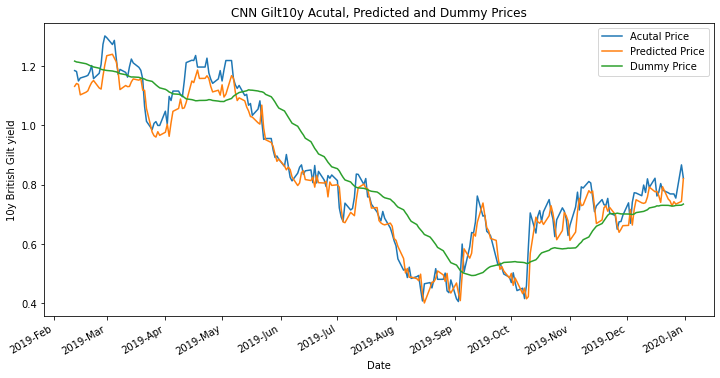

In [16]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

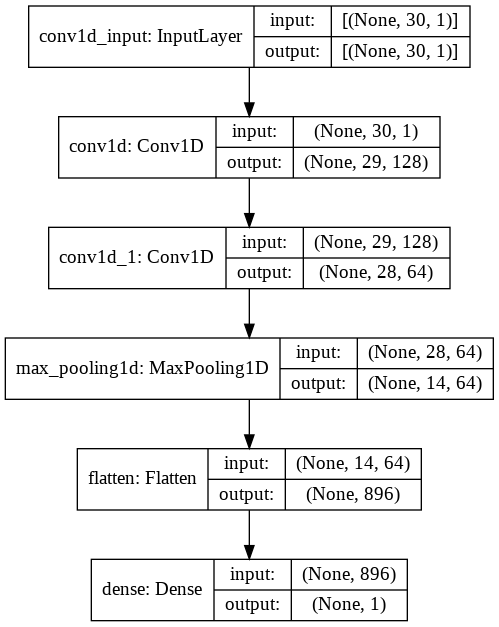

In [17]:
plot_model(model, show_shapes=True, expand_nested=True)

In [18]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0028949145606454126
RMSE:  0.05380441023415657
MAE:  0.04302848737753691
Dummy MSE:  0.013891737694778073
Dummy RMSE:  0.11786321603782103
Dummy MAE:  0.09977998323101281


In [19]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/CNN_Gilt10y/assets
